# Import the required libraries

In [ ]:
import tensorflow as tf
import pathlib
from tqdm import tqdm
import numpy as np
import pandas as pd
import os
from cv2 import cv2

# Download the original model to colab instance

In [ ]:
!wget --no-check-certificate --no-clobber https://raw.githubusercontent.com/Karenw1004/Deeppicar-v3/main/Deeppicar-ori.hdf5

--2021-03-17 20:09:55--  https://raw.githubusercontent.com/Karenw1004/Deeppicar-v3/main/Deeppicar-ori.hdf5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3120232 (3.0M) [application/octet-stream]
Saving to: ‘Deeppicar-ori.hdf5’

Deeppicar-ori.hdf5  100%[===================>]   2.98M  --.-KB/s    in 0.03s   

2021-03-17 20:09:55 (104 MB/s) - ‘Deeppicar-ori.hdf5’ saved [3120232/3120232]



In [ ]:
mkdir models/

mkdir: cannot create directory ‘models/’: File exists


In [ ]:
mv ./Deeppicar-ori.hdf5 ./models/

# Load TFLite model and allocate tensors.

In [ ]:
# Config
model_path = "./models/Deeppicar-ori.hdf5"

In [ ]:
DEEPPICAR_MODEL = tf.keras.models.load_model(model_path)
converter = tf.lite.TFLiteConverter.from_keras_model(DEEPPICAR_MODEL)

tflite_model = converter.convert()
tflite_models_dir = pathlib.Path("/tmp/")

tflite_model_file = tflite_models_dir/'model1.tflite'
tflite_model_file.write_bytes(tflite_model)
# This will report back the file size in bytes

INFO:tensorflow:Assets written to: /tmp/tmpv6dllaw5/assets


INFO:tensorflow:Assets written to: /tmp/tmpv6dllaw5/assets


1016148

In [ ]:
tflite_model_file = '/tmp/model1.tflite'
interpreter = tf.lite.Interpreter(model_path=tflite_model_file)
interpreter.allocate_tensors()

# Evaluate the model

## We need to get the X_test, y_test (same code from Training.ipynb)


In [ ]:
!gdown https://drive.google.com/uc?id=1TLz4J4qP3ppLLeOFtmddbkIxkeLzVnaU
train_image = np.load("./preprocess_data.npy")
train_image.shape
!wget --no-check-certificate --no-clobber https://raw.githubusercontent.com/Karenw1004/Deeppicar-v3/main/preprocess_path.csv
train_df = pd.read_csv("./preprocess_path.csv")
train_df.head()
X = np.array(train_image)
y = train_df['wheel'] 

Downloading...
From: https://drive.google.com/uc?id=1TLz4J4qP3ppLLeOFtmddbkIxkeLzVnaU
To: /content/preprocess_data.npy
1.74GB [00:12, 134MB/s] 
File ‘preprocess_path.csv’ already there; not retrieving.



## Split the dataset to 60% train, 20% validation, 20% test

<font color='red'>WARNING</font><br/>
**IF YOU CHANGE THE ``random_state`` IN THIS NOTEBOOK (Inferencing.ipynb), REMEMBER TO CHANGE Training.ipynb NOTEBOOK TOO! <br/>**
<font color='blue'>NOTE</font><br/>
We cannot send or transfer variables other than saving it to pkl file which will be troublesome. **PLEASE KEEP THE ``random_state`` in both notebook to ensure same data splits**

In [ ]:
def split_stratified_into_train_val_test(X, y,frac_train, frac_val, frac_test,
                                          random_state=7):
  if frac_train + frac_val + frac_test != 1.0:
      raise ValueError(f"Train {frac_train} + val {frac_val} + test {frac_test} doesnt add up to 1!")
  X_train, X_temp, y_train, y_temp = train_test_split(X,y,stratify=y,test_size=(1.0 - frac_train),random_state=random_state)
  remaining_frac = frac_test / (frac_val + frac_test)
  X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,stratify=y_temp,test_size=remaining_frac,random_state=random_state)
  assert y.shape[0] == len(X_train) + len(X_val) + len(X_test)
  return X_train, y_train, X_val, y_val, X_test, y_test

In [ ]:
from sklearn.model_selection import train_test_split
X_train, y_train,X_val, y_val, X_test, y_test = split_stratified_into_train_val_test(X,y,0.6,0.2,0.2)

In [ ]:
import math

def rad2deg(rad):
  return 180.0 * rad / math.pi

In [ ]:
def get_action(angle_rad):
  degree = rad2deg(angle_rad)
  if degree < 15 and degree > -15:
    return "center"
  elif degree >= 15:
    return "right" 
  elif degree <-15:
    return "left"

In [ ]:
predictions = []
test_labels, test_imgs = [], []

input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

length = len(X_val)
accuracy = 0 
for i in tqdm(range(length)):
  img = X_val[i]
  img = np.expand_dims(img, axis=0).astype(np.float32)
  test_imgs.append(img)

  interpreter.set_tensor(input_index, img)
  # Run inference.
  interpreter.invoke()
  # Post-processing: remove batch dimension and find the digit with highest probability.

  predicted_angle = interpreter.get_tensor(output_index)[0][0]
  groundtrue_angle = y_val.iloc[i]
  predictions.append(predicted_angle)
  test_labels.append(groundtrue_angle)

  if get_action(predicted_angle) == get_action(groundtrue_angle):
    accuracy = accuracy + 1

print(f"\nAccuracy is {(accuracy/length)*100:.2f}%")

100%|██████████| 2200/2200 [00:15<00:00, 146.07it/s]


Accuracy is 72.68%


In [ ]:
import matplotlib.pylab as plt

  
def plot_image(i, prediction_array, groundtrue_array, img_array, match):
  predicted_angle, groundtrue_angle, img = prediction_array[i], groundtrue_array[i], img_array[i]

  predicted_label = get_action(predicted_angle)
  groundtrue_label = get_action(groundtrue_angle)
  
  # prediction (angle), prediction (action), ground truth (angle), ground truth (action), 
  # print(predicted_angle, groundtrue_angle, predicted_label, groundtrue_label)
  
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  img = np.squeeze(img)
  plt.imshow(img, cmap=plt.cm.binary)
  
  if predicted_label == groundtrue_label:
    color = 'green'
    match += 1
  else:
    color = 'red'
  
  plt.xlabel(f"{predicted_angle:.2f} {predicted_label}  Actual:{groundtrue_label}"
  , color=color)

  return match

# Visualisation

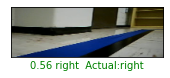

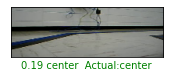

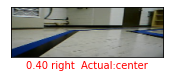

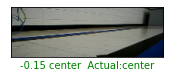

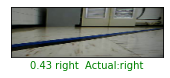

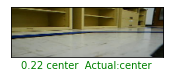

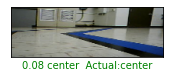

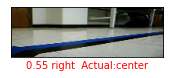

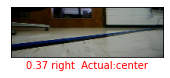

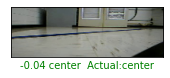

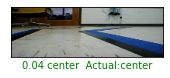

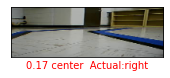

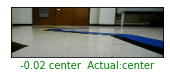

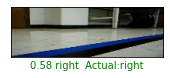

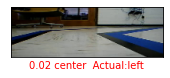

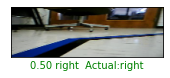

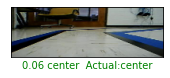

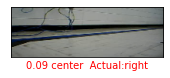

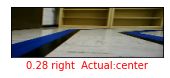

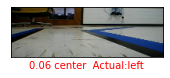

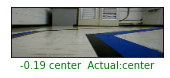

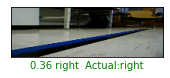

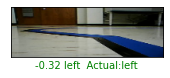

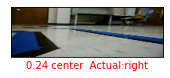

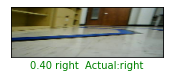

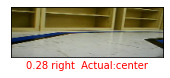

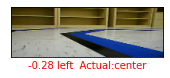

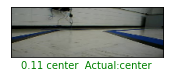

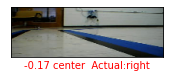

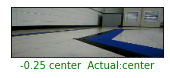

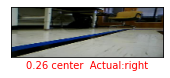

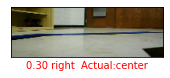

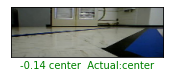

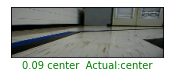

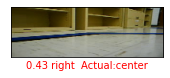

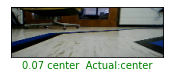

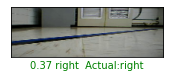

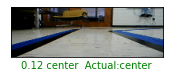

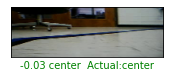

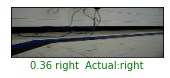

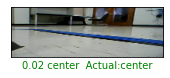

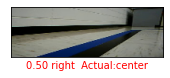

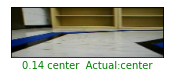

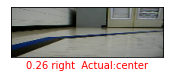

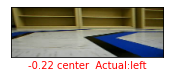

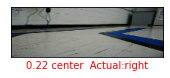

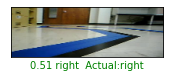

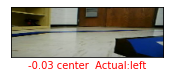

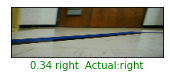

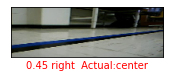

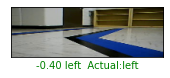

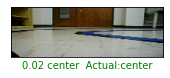

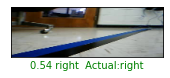

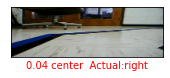

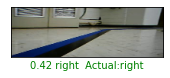

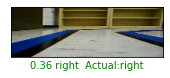

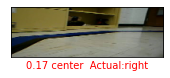

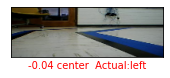

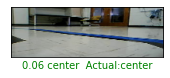

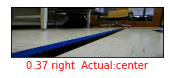

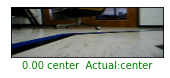

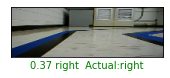

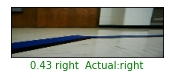

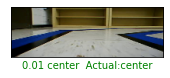

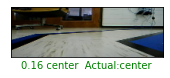

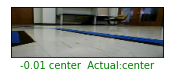

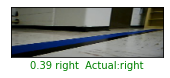

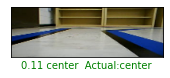

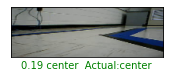

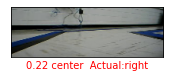

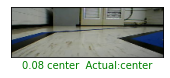

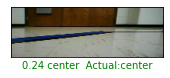

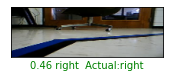

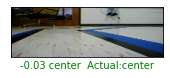

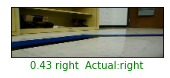

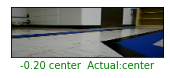

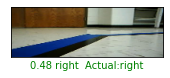

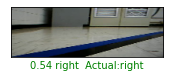

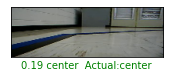

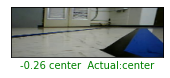

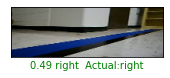

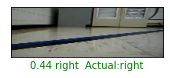

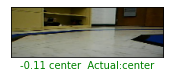

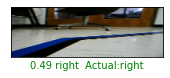

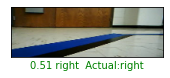

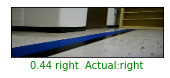

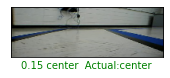

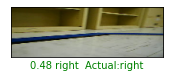

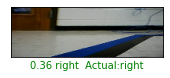

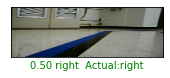

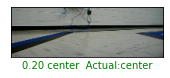

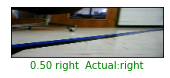

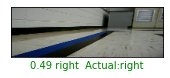

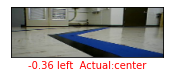

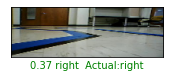

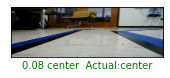

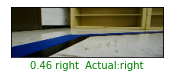

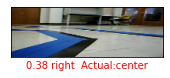

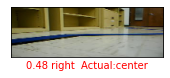

In [ ]:
#@title Visualize the outputs { run: "auto" }
index = 22 #@param {type:"slider", min:0, max:99, step:1}
accuracy = 0
for index in range(0,99):
  plt.figure(figsize=(6,3))
  plt.subplot(1,2,1)
  accuracy = plot_image(index, predictions, test_labels, test_imgs, accuracy)
  plt.show()

In [ ]:
print(f"Accuracy is {(accuracy/100)*100}%")

Accuracy is 70.0%


## Visualize the network

In [ ]:
# from matplotlib import pyplot

# successive_outputs = [layer.output for layer in model.layers[1:]]
# layer_names = [layer.name for layer in model.layers]

# visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# feature_maps = visualization_model.predict(X_val[0])

# square = 3
# layer_number = 0
# for fmap in feature_maps:
#   if len(fmap.shape) == 4:
#     ix = 1
#     for _ in range(square):
#       ax = pyplot.subplot(square, square, ix)
#       ax.set_xticks([])
#       ax.set_yticks([])
#       # plot filter channel in grayscale
#       pyplot.imshow(fmap[0, :, :, ix-1], cmap='gray')
#       ix += 1
#     plt.title(layer_name[layer_number])
#     # show the figure
#     pyplot.show()
#   layer_number +=1
  

# Run Model

In [ ]:
!sudo apt-get install python3-magic

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-magic is already the newest version (2:0.4.15-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
!pip show python-magic

Name: python-magic
Version: 0.4.16
Summary: File type identification using libmagic
Home-page: http://github.com/ahupp/python-magic
Author: Adam Hupp
Author-email: adam@hupp.org
License: MIT
Location: /usr/lib/python3/dist-packages
Requires: 
Required-by: 


<font color='blue'>NOTE</font><br/>
Make sure you installed the readily available magic libray at PYPI as it is easily installed via pip into virtualenv environments.
As of the date of this documentation is created, there are two version of python-magic **python-magic-0.4.22** (recommended) and python-magic-5.19.1

In [ ]:
def preprocess(img):
  assert img_channels == 3 # for now we expect a color image
  img = cv2.resize(img, (img_width, img_height))
  img = img / 255.
  return img

In [ ]:
# Config
img_height = 66
img_width =  200
img_channels = 3
input_shape = [ img_height, img_width, img_channels]
NFRAMES = 1000

In [ ]:
def get_classes(img):
  img = image.img_to_array(img)
  img = preprocess(img)
  img = np.expand_dims(img, axis=0).astype(np.float32)
  image_tensor = np.vstack([img])
  # classes = model.predict(image_tensor)

  interpreter.set_tensor(input_index, img)
  interpreter.invoke()
  classes = interpreter.get_tensor(output_index)

  return classes

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import magic
from google.colab.patches import cv2_imshow

print("For simplicity, we are only going to visualize one file (Type:Video).")
uploaded = files.upload()

for index, filename in enumerate(uploaded.keys()):
  if index > 0:
    print("Detecting more than one file...\nGoogle colab cannot restrict users to upload only one file\nbreak")
    break
  # predicting Video
  path = '/content/' + filename
  file_type = magic.from_file(path, mime=True)
  print(file_type)
  is_video = True if "video" in file_type else False

  if is_video:
    assert os.path.isfile(path)
    cap = cv2.VideoCapture(path)
    curFrame = 0
    writer = None
    while cap.isOpened():
      if curFrame < NFRAMES:
        ret, frame = cap.read()

        if cv2.waitKey(1) & 0xFF == ord('q'):
          break

        if writer is None:
          # Ref: https://stackoverflow.com/questions/58924926/cv2-imshow-doesnt-render-video-file-in-google-colab
          fourcc = cv2.VideoWriter_fourcc(*"MJPG")
          output_path = "output.avi"
          writer = cv2.VideoWriter(output_path, fourcc, 30,
                  (frame.shape[1], frame.shape[0]), True)
          
        classes = get_classes(frame)
        rad = classes[0][0]
        deg = rad2deg(rad)

        # Visualize the video
        font = cv2.FONT_HERSHEY_SIMPLEX
        currDeg = "Pred Deg: " + str(deg)
        if (deg < -30):
          line_color = (255, 0, 0) # Red = Right
        elif (deg > 30):
          line_color = (0, 255, 0) # Blue = Left
        else:
          line_color = (255, 255, 255) # White = Center

        # Calculation to draw the line
        yCor = 200-( 80 + 120*(math.sin(math.radians(90-deg))) ) +80
        xCor = 160 + 120*(math.cos(math.radians(90-deg)))
        calPoint = (int(xCor),int(yCor))
        frame = cv2.line(frame, pt1=calPoint, pt2=(160, 200), color=line_color,thickness=3, lineType=9, shift=0)
        frame =  cv2.putText(frame,currDeg,(5,20),font,.5 ,(0,255,255), 2, cv2.LINE_AA)

        writer.write(frame)
        curFrame += 1
      else: 
        writer.release()
        cap.release()
        cv2.destroyAllWindows()
        break
  else:
    raise ValueError("Only support image and video for Deeppicar-v3")
  

For simplicity, we are only going to visualize one file (Type:Video).


Saving out-video-5.avi to out-video-5.avi
video/x-msvideo


## Since google colab only support playing video in mp4, let's convert avi to mp4 format

In [ ]:
!ffmpeg -i output.avi output.mp4

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
import io
import base64
from IPython.display import HTML

video = io.open("output.mp4", 'r+b').read()
encoded = base64.b64encode(video)
HTML(data=f'''
    <video alt="test" controls>
  <source src="data:video/mp4;base64,{encoded.decode('ascii')}" type="video/mp4"/>
    </video>''')